In [3]:
from paper.sysproduction.update_historical_prices import update_historical_prices
from paper.topic.common_import import *
from sysquant.estimators.vol import simple_ewvol_calc
from scipy.stats import gmean

# update_historical_prices()

def screen(look_back_days, vol_look_back_days, end=pd.Timestamp.now(), ins = 'BTC-USDT-Binance'):
    start = end - np.timedelta64(look_back_days + vol_look_back_days , "D")
    period = (start, end)
    fre = 'Hour'
    vol_look_back_hours = vol_look_back_days * 24

    '''Data'''
    history = artic_lib.read('{}/{}'.format(fre, ins)).data
    volume = select_period(history['VOLUME'], period)
    close = select_period(history['FINAL'].rename('close price'), period)
    print('mean={}, gmean={}, pct_chg={}'.format(close.mean(), gmean(close), close[-1] / close[0] - 1))

    '''Feature'''
    feature1 = close
    fig = feature1.plot(legend=True, figsize=(16, 4))
    plt.title('{}/{} {} - {}'.format(fre, ins, close.index[0], close.index[-1]))

    # feature2 = simple_ewvol_calc(close.pct_change(), days=vol_look_back_hours, min_periods=vol_look_back_hours).rename('vol') * np.sqrt(24) * np.sqrt(365)
    # feature2.plot(legend=True, figsize=(16, 4), secondary_y=True)

    feature3 = volume
    feature3.plot(legend=True, figsize=(16, 4), secondary_y=True, lw=0.5)
    plt.show()

    plt.figure(figsize=(8,4))
    plt.title('Return Distribution')
    _ = sns.histplot(feature1.pct_change().rename('return'), log_scale=(False, True), binwidth=0.004)
    plt.show()
    # show(feature1.pct_change().sort_values())

#### Market Updates

mean=23679.1125, gmean=23661.456939094118, pct_chg=0.09315177166862743


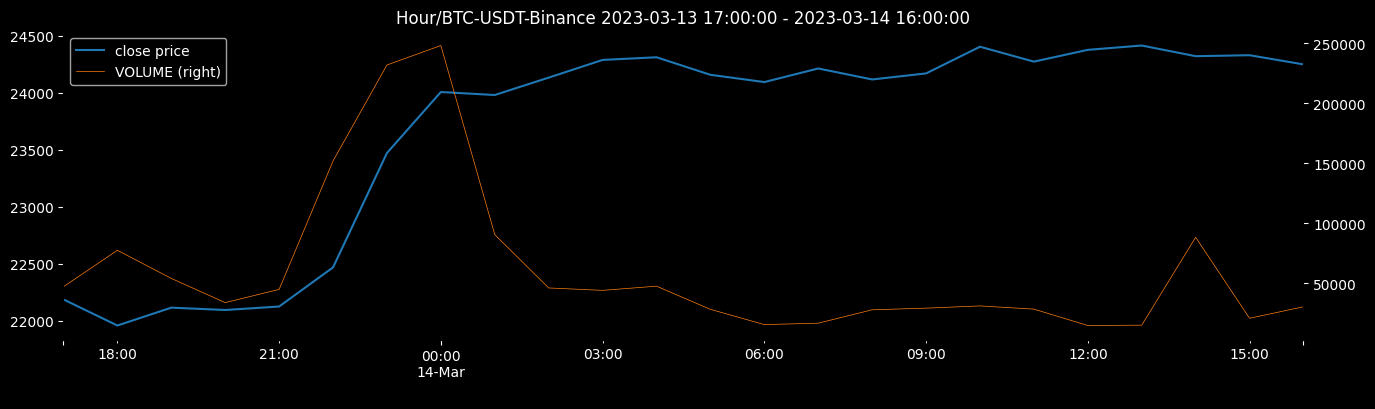

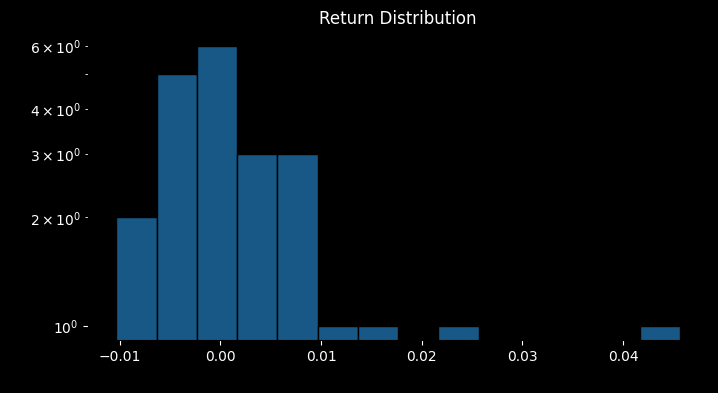

mean=22481.99583333333, gmean=22432.762693057408, pct_chg=0.1907039086396598


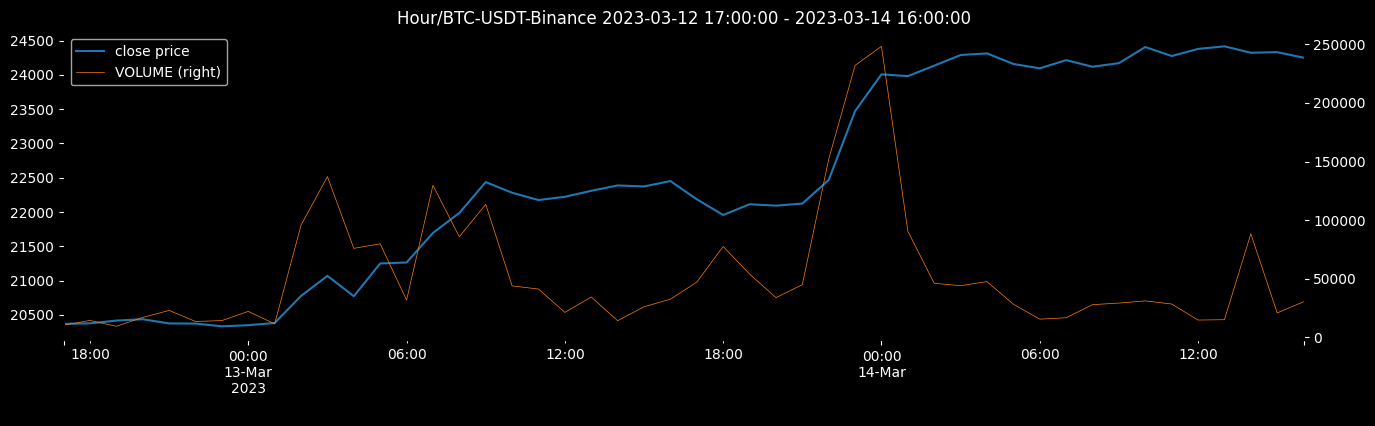

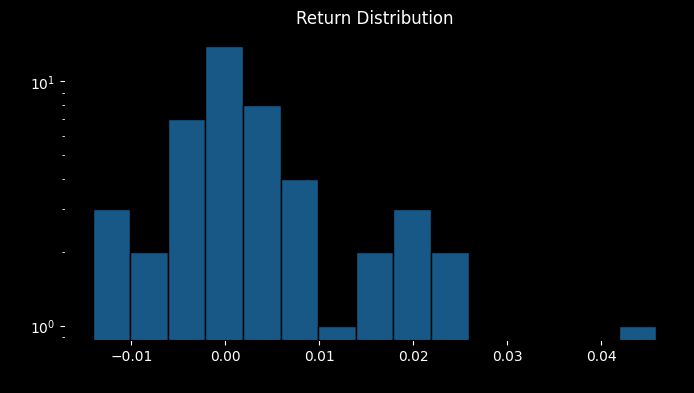

mean=21451.680952380946, gmean=21413.21102158166, pct_chg=0.08219098616688991


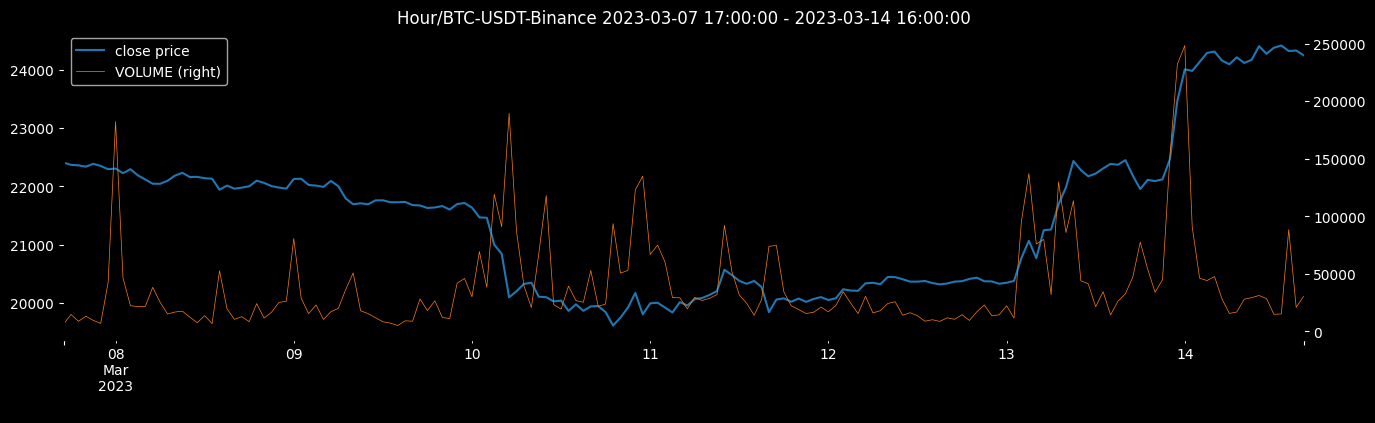

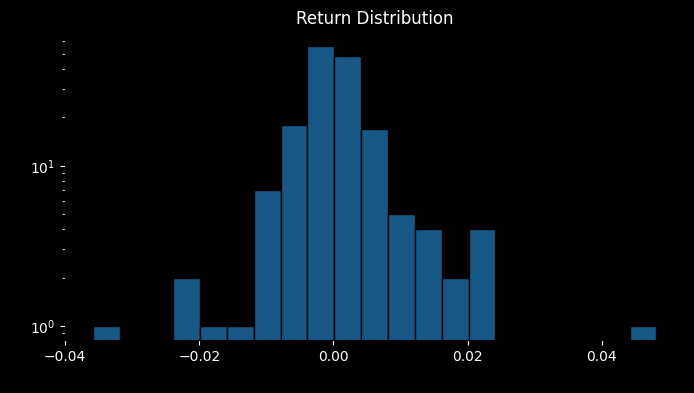

In [4]:
screen(look_back_days=1, vol_look_back_days=0)
screen(look_back_days=2, vol_look_back_days=0)
screen(look_back_days=7, vol_look_back_days=0)

mean=22264.320384615403, gmean=22185.538663410007, pct_chg=0.4317366047181621


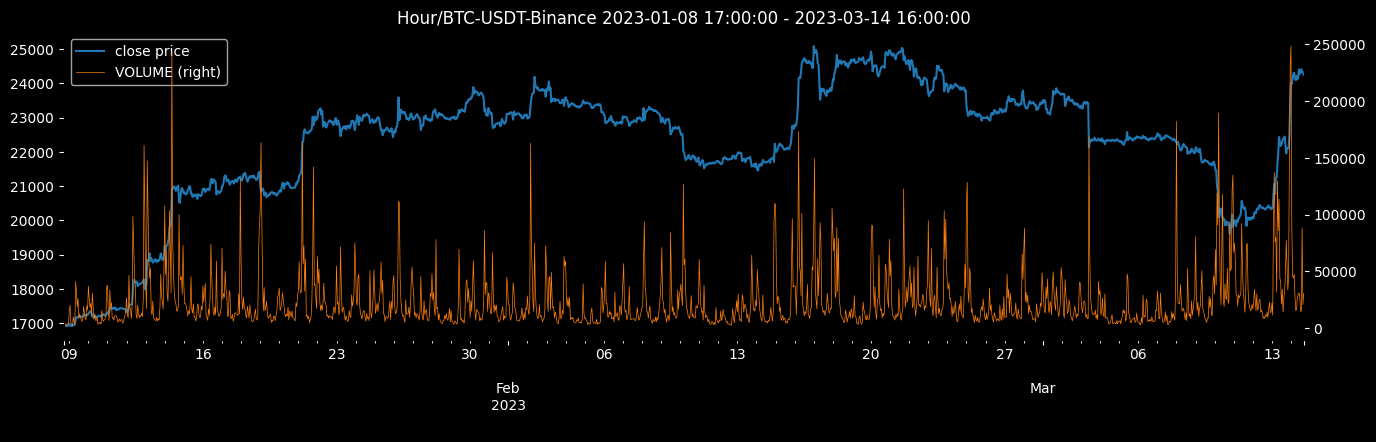

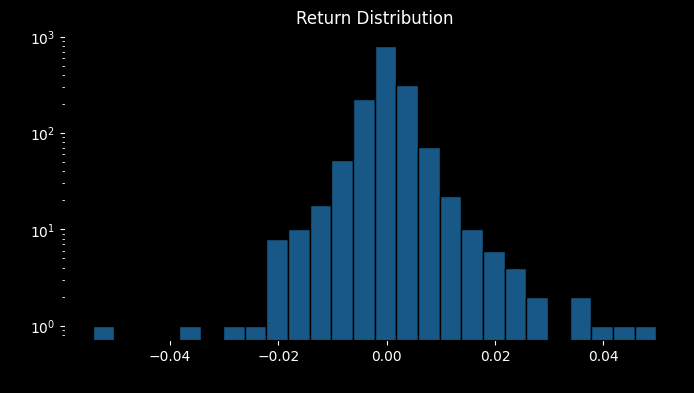

mean=20565.530043859635, gmean=20351.754834004932, pct_chg=0.41029756401086304


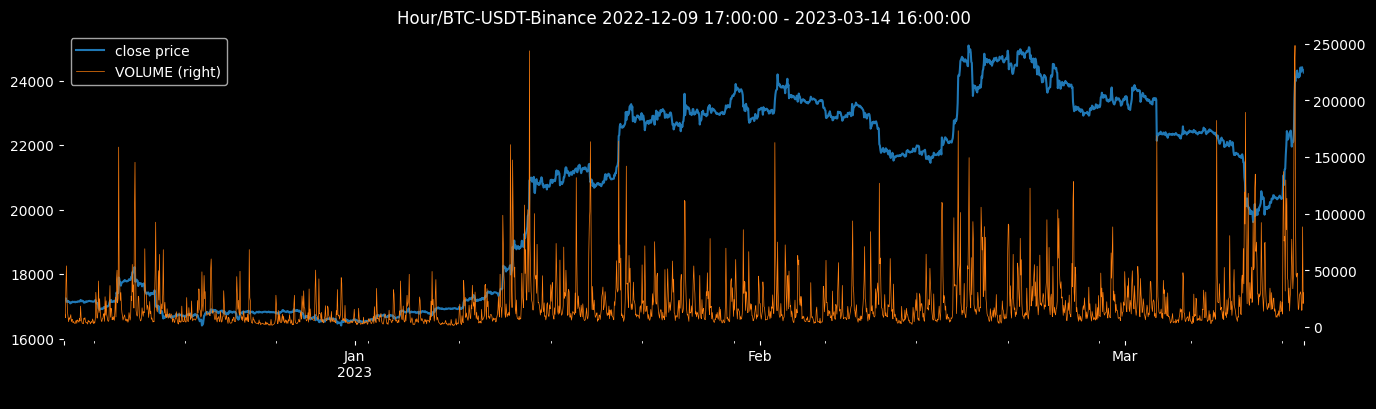

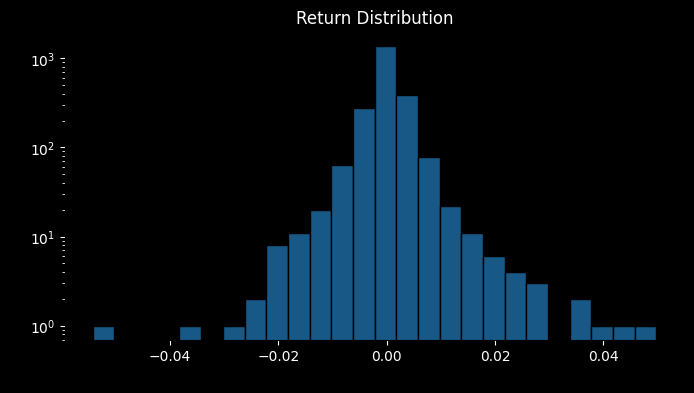

mean=19640.1343, gmean=19409.975841861877, pct_chg=0.3369810301389802


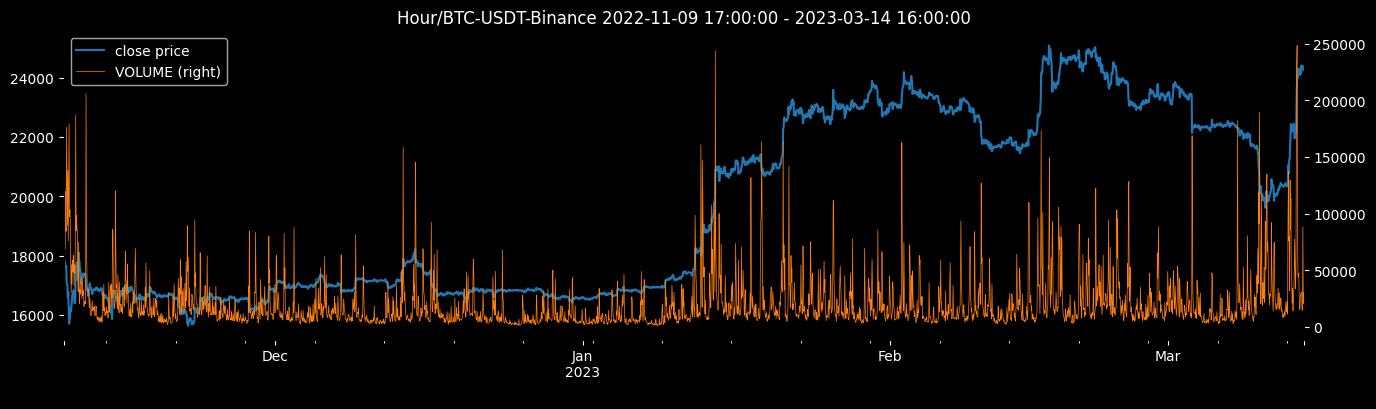

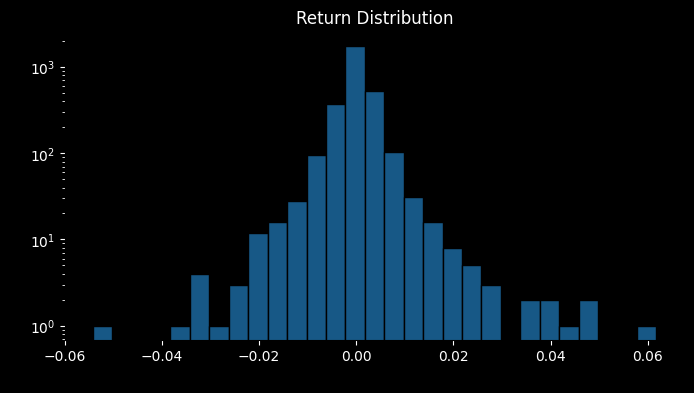

mean=19681.815376344104, gmean=19492.53756764188, pct_chg=0.2612607458797711


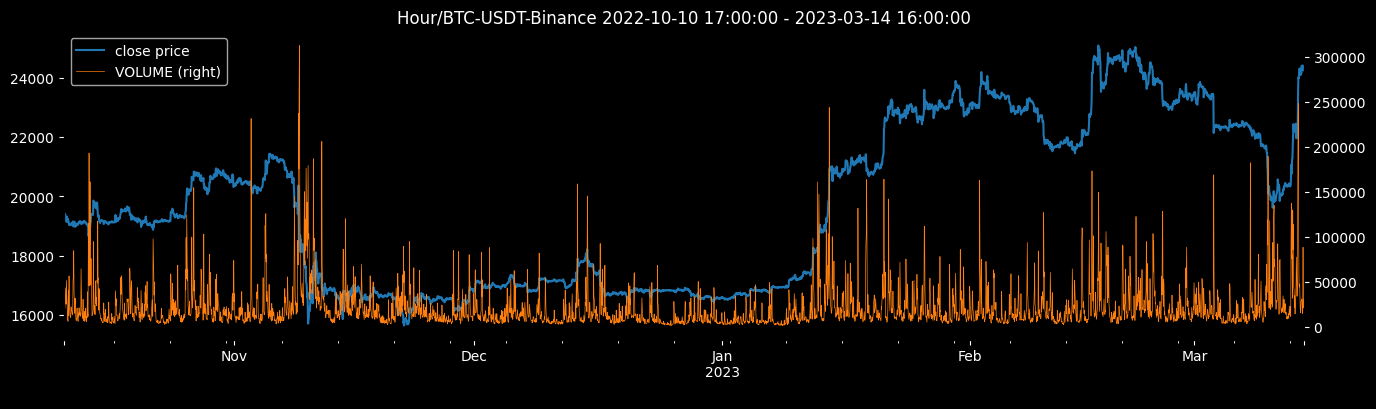

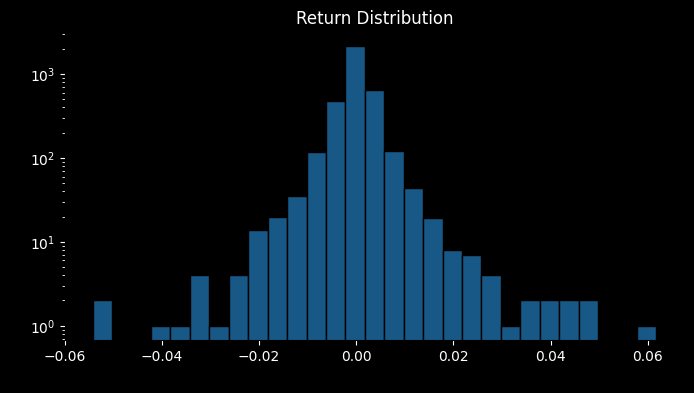

In [5]:
vol_look_back_days = 35
screen(look_back_days=30, vol_look_back_days=vol_look_back_days)
screen(look_back_days=60, vol_look_back_days=vol_look_back_days)
screen(look_back_days=90, vol_look_back_days=vol_look_back_days)
screen(look_back_days=30 * 4, vol_look_back_days=vol_look_back_days)

#### History

mean=17285.2617626648, gmean=17240.151046080016, pct_chg=-0.18855180980980013


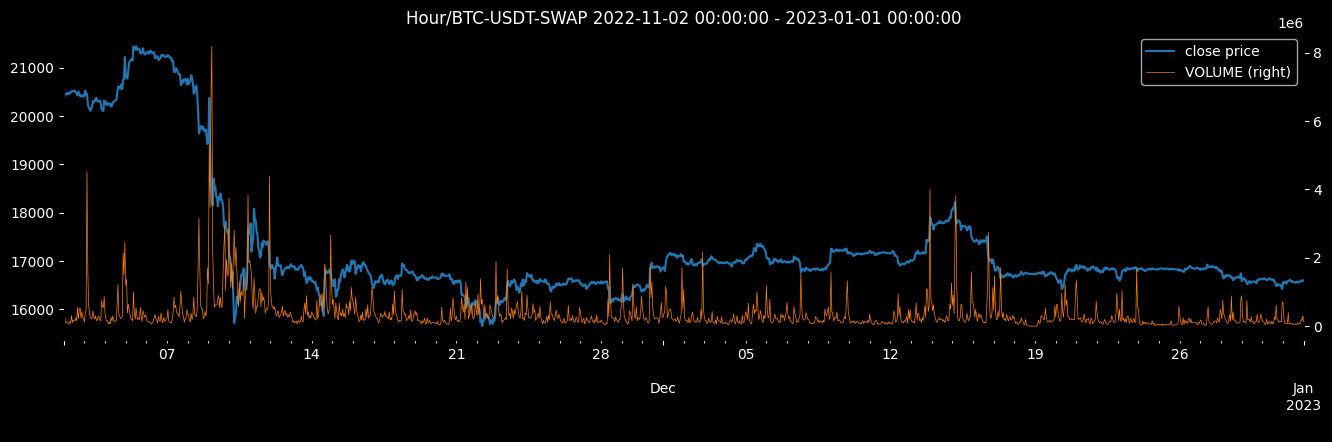

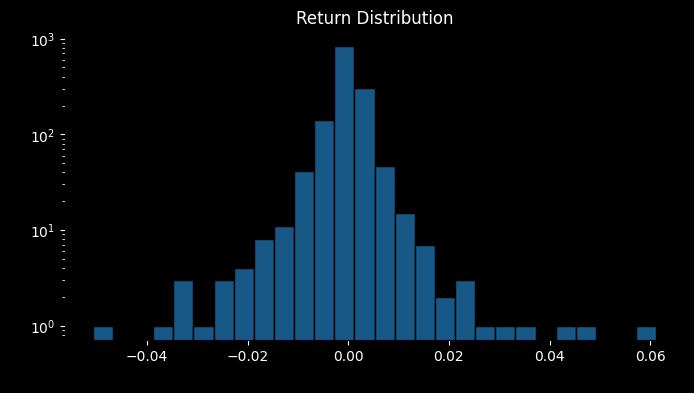

In [6]:
# screen(look_back_days=1, vol_look_back_days=0, end=pd.Timestamp('2022-11-10'))
# screen(look_back_days=2, vol_look_back_days=0, end=pd.Timestamp('2022-11-10'))
# screen(look_back_days=3, vol_look_back_days=0, end=pd.Timestamp('2022-11-10'))

screen(look_back_days=30 * 2, vol_look_back_days=0, end=pd.Timestamp('2023-01-01'), ins='BTC-USDT-SWAP')
# screen(look_back_days=30 * 6, vol_look_back_days=0, end=pd.Timestamp('2023-01-01'), ins='BTC-USDT-SWAP')
# screen(look_back_days=30 * 12, vol_look_back_days=0, end=pd.Timestamp('2023-01-01'), ins='BTC-USDT-SWAP')
# screen(look_back_days=30 * 30, vol_look_back_days=0, end=pd.Timestamp('2023-01-01'), ins='BTC-USDT-SWAP')

#### Position Updates

In [7]:
for ins in system.portfolio.get_instrument_list():
    pos = system.portfolio.get_actual_position(ins).rename(ins)
    show(pos)

2023-03-14 11:14:04 {'type': 'base_system'}  Following instruments are 'duplicate_markets' ['Another_thing', 'bad_thing'] 
2023-03-14 11:14:04 {'type': 'base_system'}  Following instruments are marked as 'ignore_instruments': not included: ['EXAMPLE']
2023-03-14 11:14:04 {'type': 'base_system'}  Following instruments removed entirely from sim: ['Another_thing', 'EXAMPLE', 'bad_thing']
2023-03-14 11:14:04 {'type': 'base_system', 'stage': 'portfolio', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating actual position for BTC-USDT-SWAP
2023-03-14 11:14:04 {'type': 'base_system', 'stage': 'portfolio', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating notional position for BTC-USDT-SWAP
2023-03-14 11:14:04 {'type': 'base_system', 'stage': 'portfolio'}  Calculating instrument weights
2023-03-14 11:14:04 {'type': 'base_system', 'stage': 'portfolio'}  Calculating raw instrument weights
2023-03-14 11:14:04 {'type': 'base_system'}  Following instruments are 'duplicate_markets' ['Another_thing', 'ba

/Users/weiranzhou/Code/pysystemtrade/sysobjects/futures_per_contract_prices.py:35: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._as_df = price_data_as_df


2023-03-14 11:14:04 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating daily prices for BTC-USDT-SWAP
2023-03-14 11:14:05 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating daily volatility for BTC-USDT-SWAP
2023-03-14 11:14:05 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating daily prices for BTC-USDT-SWAP
2023-03-14 11:14:05 {'type': 'base_system', 'stage': 'combForecast', 'instrument_code': 'BTC-USDT-SWAP'}  Calculating combined forecast for BTC-USDT-SWAP
2023-03-14 11:14:05 {'type': 'base_system', 'stage': 'forecastScaleCap', 'instrument_code': 'BTC-USDT-SWAP', 'rule_variation_name': 'breakout10'}  Calculating capped forecast for BTC-USDT-SWAP breakout10
2023-03-14 11:14:05 {'type': 'base_system', 'stage': 'rules', 'instrument_code': 'BTC-USDT-SWAP', 'rule_variation_name': 'breakout10'}  Calculating raw forecast BTC-USDT-SWAP for breakout10
2023-03-14 11:14

2023-03-14 11:14:14 {'type': 'base_system', 'stage': 'portfolio', 'instrument_code': 'ETH-USDT-SWAP'}  Calculating actual position for ETH-USDT-SWAP


/Users/weiranzhou/Code/pysystemtrade/sysobjects/futures_per_contract_prices.py:35: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._as_df = price_data_as_df


0.9298497708439812


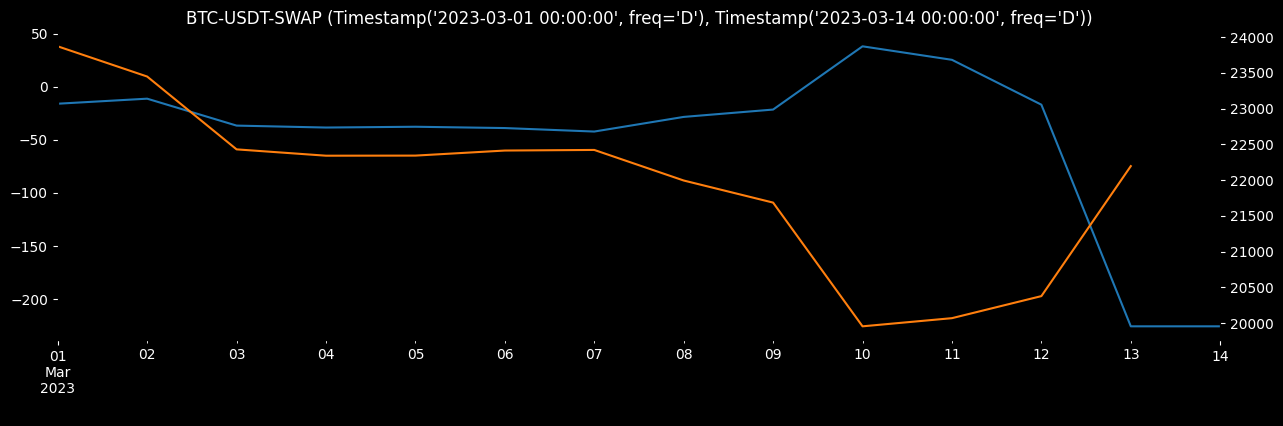

In [12]:
pl = system.accounts.portfolio()
# print(pl.sharpe())
# print(pl.calmar())
# print(pl.ann_mean())
# print(pl.avg_drawdown())
# print(pl.worst_drawdown())
# print(pl.time_in_drawdown())

# pct_pl = (pl / system.accounts.get_notional_capital()).rename('pct pl')
# pct_pl.plot(secondary_y=True, figsize=(15,4))
cum_pl = pl.tail(14).cumsum().rename('cum pl')
cum_pl.plot(figsize=(15,4), title='{} {}'.format('portfolio', (cum_pl.index[0], cum_pl.index[-1])))

btc = system.data.daily_prices('BTC-USDT-SWAP').tail(14)
btc.plot(figsize=(15,4), title='{} {}'.format('BTC-USDT-SWAP', (btc.index[0], btc.index[-1])), secondary_y=True)
print(btc.iloc[-2] / btc.iloc[0])
# print(system.accounts.portfolio().stats())
# show(system.portfolio.get_instrument_weights())
# print((1500+2500)/1500)

In [9]:
st = '2020-11-01'
et = '2021-01-01'

pl = system.accounts.portfolio().to_frame()
pl = select(pl, st, et)
pct_pl = (pl / system.accounts.get_notional_capital())
pct_pl.plot(secondary_y=True, figsize=(15,5))
cum_pl = pl.cumsum(axis=0)
cum_pl.plot(figsize=(15,5))
plt.show()

btc = system.data.daily_prices('BTC-USDT-SWAP')
btc = select(btc, st, et)
btc.plot(figsize=(15,5))
btc.pct_change().plot(secondary_y=True)

NameError: name 'select' is not defined

In [ ]:
import pandas as pd
st = '2020-11-16'
et = '2020-12-01'

position_list = []
for ins in system.portfolio.get_instrument_list():
    if 'DOGE' in ins:
        continue
    position = system.portfolio.get_actual_position(ins).rename(ins)
    position = select(position, st, et)
    position_list.append(position)
pd.concat(position_list, axis=1).plot(secondary_y=True, figsize=(15,4), legend=True)
plt.show()

btc = system.data.daily_prices('BTC-USDT-SWAP')
btc = select(btc, st, et)
btc.plot(figsize=(15,4))
btc.pct_change().rename('pct change').plot(secondary_y=True, legend=True)

print(19_000 * 5 * 0.01  / system.accounts.get_notional_capital() )

In [ ]:
import pandas as pd
from syscore.dateutils import ROOT_BDAYS_INYEAR


st = '2020-11-16'
et = '2020-12-01'

tmp_list = []
for ins in system.portfolio.get_instrument_list():
    tmp = system.positionSize.get_price_volatility (ins).rename(ins)
    tmp = select(tmp, st, et)
    tmp_list.append(tmp)
pd.concat(tmp_list, axis=1).plot(secondary_y=True, figsize=(15,4), legend=True)
plt.show()

btc = system.data.daily_prices('BTC-USDT-SWAP')
btc = select(btc, st, et)
btc.plot(figsize=(15,4))
btc.pct_change().plot(secondary_y=True)

print(ROOT_BDAYS_INYEAR * 3)

In [ ]:
import ccxt
from paper.sysinit.scrape_okx_history_prices import fetch_once

st = '2020-11-21T00:00+00' 
et = '2020-12-01' 
exchange = ccxt.binance()
exchange = ccxt.binanceusdm()
exchange = ccxt.okex5()
symbol = 'BTC/USDT'
symbol = 'BTC-USDT-SWAP'
df = fetch_once(st, symbol, '1d', exhcnage=exchange)
prices = df[df.index<=et]
prices = prices.loc[:, 4]
prices.plot(figsize=(15,5))
prices.pct_change().rename('pct change').plot(figsize=(15,5), secondary_y=True, legend=True)

In [ ]:
import ccxt
from paper.sysinit.scrape_okx_history_prices import fetch_once

st = '2020-11-25T10:00+08' 
et = '2020-11-27' 
exchange = ccxt.binance()
exchange = ccxt.binanceusdm()
exchange = ccxt.okex5()
symbol = 'BTC/USDT'
symbol = 'BTC-USDT-SWAP'
df = fetch_once(st, symbol, '1h', exhcnage=exchange)
prices = df[df.index<=et]
prices = prices.loc[:, 4]
prices.plot(figsize=(15,5))
prices.pct_change().plot(figsize=(15,5), secondary_y=True)

In [ ]:
show(system.positionSize.get_subsystem_position('BTC-USDT-SWAP').tail(30))
system.accounts.pandl_for_subsystem('BTC-USDT-SWAP').tail(30).cumsum().plot()
print(250 / 1500)
print(30 / (361 ** 0.5))

In [ ]:
system.accounts.pandl_for_subsystem('BTC-USDT-SWAP').stats()
system.accounts.pandl_for_subsystem('BTC-USDT-SWAP').cumsum().plot()

In [ ]:
s1 = system.rawdata.normalised_price_for_asset_class("BTC-USDT-SWAP").rename('asset class')
s2 = system.rawdata.get_cumulative_daily_vol_normalised_returns("BTC-USDT-SWAP").rename('BTC')
s3 = system.rawdata.get_cumulative_daily_vol_normalised_returns("ETH-USDT-SWAP").rename('ETH')
s4 = system.rawdata.get_cumulative_daily_vol_normalised_returns("BNB-USDT").rename('BNB')
# ss = [s1, s2, s3, s4]
ss = [select(s, '2023-01-01', '2023-12-31') for s in [s1, s2, s3, s4]]
ss = [s - s.iloc[0] for s in ss]

pd.concat(ss, axis=1).plot(legend=True, figsize=(15,8))
s2
# system.rawdata.get_cumulative_daily_vol_normalised_returns("ADA-USDT-SWAP").rename('ADA').plot(legend=True)
# system.rawdata.get_cumulative_daily_vol_normalised_returns("XRP-USDT-SWAP").rename('XRP').plot(legend=True)

In [ ]:
ins_list = ['BTC-USDT-SWAP', 'ETH-USDT-SWAP', 'BNB-USDT']

'''portfolio'''
# print(system.accounts.portfolio().stats())
# system.accounts.portfolio().cumsum().rename('port').plot(legend=True, figsize=(15,8))
# plt.show()


for ins in ins_list:
    curve = system.accounts.pandl_for_subsystem(ins)
    curve.cumsum().rename(ins).plot(legend=True, figsize=(15,8))
    print('{} sharpe={} calmar={}'.format(ins, curve.sharpe(), curve.calmar()))
    plt.show()

    for rule in ['ewmac4', 'relmomentum10']:
        curve = system.accounts.pandl_for_instrument_forecast(ins, rule)
        curve.cumsum().rename('{}-{}'.format(ins, rule)).plot(legend=True, figsize=(15,8))
        print('{}={} sharpe={} calmar={}'.format(ins, rule, curve.sharpe(), curve.calmar()))
    plt.show()


In [ ]:
days = 14
daily = system.rawdata.get_daily_prices('BTC-USDT-SWAP').rename('daily').tail(days)
hourly = system.rawdata.get_hourly_prices('BTC-USDT-SWAP').rename('hourly').tail(24 * days)

hourly.plot(figsize=(15,6), legend=True)
daily.index = [date + pd.Timedelta('17h') for date in daily.index]
daily.plot(figsize=(15,6), legend=True, style='o')

In [ ]:
show(daily)
show(hourly)